In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np
import timeit 
import os
from datetime import datetime
from datetime import timedelta

#NB : timeit.default_timer() auto chooses timeing function for os, nicer than time.time() or time.clock()
print ("libraries imported")

libraries imported


In [2]:
start_time = timeit.default_timer()
df1 = pd.read_csv('PD1.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  4.138481915197769


In [3]:
start_time = timeit.default_timer()
df2 = pd.read_csv('PD2.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.5139527064479807


In [4]:
start_time = timeit.default_timer()
df = df1.set_index('TimeStamp').join(df2.set_index('TimeStamp'))
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head(4))

elapsed time :  0.6227605506835419


In [5]:
start_time = timeit.default_timer()
df.index = pd.to_datetime(df.index)
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head())

elapsed time :  0.024424985558999524


In [6]:
print(df.shape)
dfColNames = list(df)

(60000, 792)


In [7]:

print ("Number of NAN values", df.shape[0]-df['346TT035/PV.V'].count())
print ("% of NAN values", (df.shape[0]-df['346TT035/PV.V'].count())/df.shape[0])


Number of NAN values 1544
% of NAN values 0.0257333333333


In [8]:
# Remove any sensors where values are missing in >10% of rows.
cols2Drop = []
for colName in dfColNames:
    percentNaN = (df.shape[0]-df[colName].count())/df.shape[0]
    #print ("colName:", colName, ",\t\t\t percentNaN:", percentNaN)
    if percentNaN > 0.1:
        #print ("colName: %40s  percentNaN: %f" % (colName, percentNaN) )
        cols2Drop.append(colName)
#print ("cols2Drop=", cols2Drop)
print ("len(cols2Drop):", len(cols2Drop))
print (df.shape)
df = df.drop(cols2Drop, axis=1)
print (df.shape)

len(cols2Drop): 311
(60000, 792)
(60000, 481)


In [9]:
df.dropna(subset=['346TT035/PV.V'], how='all', inplace = True)

In [10]:
df.shape

(58456, 481)

In [11]:
print ("Number of NAN values", df.shape[0]-df['PrcTotals/321-WQ-024.V'].count())
print ("Number of Non NAN values", df['PrcTotals/321-WQ-024.V'].count())

print (type(df))
df['PrcTotals/321-WQ-024.V'].describe()

Number of NAN values 0
Number of Non NAN values 58456
<class 'pandas.core.frame.DataFrame'>


count    58456.000000
mean     21214.505728
std        615.138200
min      20217.620000
25%      20707.700000
50%      21288.975000
75%      21801.280000
max      22215.140000
Name: PrcTotals/321-WQ-024.V, dtype: float64

NB: there are _ZERO_ missing values in column 'PrcTotals/321-WQ-024.V'.  
Question appears to be flawed or misleading   
What would be a better imputation scheme & why? 
ans: Question is redundant for column 'PrcTotals/321-WQ-024.V' as there were no missing values.
DataFrame.interpolate() enables several methods to fill missing values.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
some of the methods available include : ‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’,
‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’  

As a first pass, linear interpolation is a significant improvement over replacing missing values with mean. Interpolation is useful where short gaps in data are surrounded by sensible and accurate data. Longer gaps are likely to omit a range of value movements for the missing data. Higher order polynomial data fitting can be useful but also carries the risk of missing events in the missing data. 

<IPython.core.display.Javascript object>


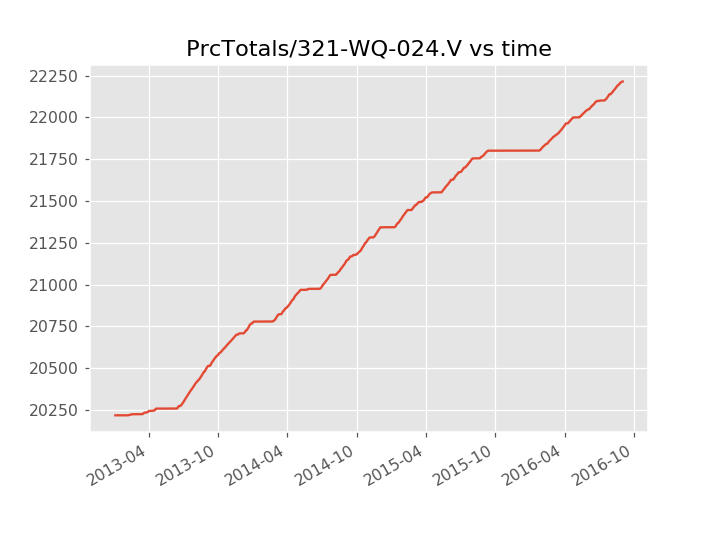

In [12]:
plt.close('all')
fig, ax = plt.subplots(1)
plt.title('PrcTotals/321-WQ-024.V vs time')
ax.plot(df['PrcTotals/321-WQ-024.V'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#plt.title('fig.autofmt_xdate fixes the labels')

d. Challenge question (optional):   
Impute all other missing sensor values using a more robust technique   
(including but not limited to interpolation or kNN imputation).   
What are the advantages & disadvantages of your chosen imputation technique? 
---------------
Notes: col 'AS01-ScanTime/OB82T2.V' has 285 str values which count as NaN values col 'ACP:P:C2 TT Control/LaMvX_DB.PV_TipMv' has 2 float values which count as NaN values

In [13]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
#summaries missing sensor values in all columns
print ( "%45s %10s %10s" % ("Column Name", "#Non NAN", "Count NAN") )
count = 0
for colName in list(df):
    #print (colName, df[colName].count(), df.shape[0]-df[colName].count())
    if df.shape[0]-df[colName].count()!=0 and df.shape[0]-df[colName].interpolate().count()!=0 and not isinstance(df[colName][0], np.float64):
        print ("type:", type(df[colName][0]))
        print ( "%45s %10d %10d" % (colName, df[colName].count(), df.shape[0]-df[colName].count() ))
        print ( "%45s %10d %10d" % (colName, df[colName].interpolate().count(), df.shape[0]-df[colName].interpolate().count() ))
        print ("-------------------------------------------------------------------")
        count += 1
    
print ("# rows NOT fixed by interpolation :", count)

                                  Column Name   #Non NAN  Count NAN
type: <class 'str'>
                       AS01-ScanTime/OB82T2.V      58171        285
                       AS01-ScanTime/OB82T2.V      58171        285
-------------------------------------------------------------------
type: <class 'float'>
         ACP:P:C2$T$Control/LaMvX_DB.PV_TipMv      58454          2
         ACP:P:C2$T$Control/LaMvX_DB.PV_TipMv      58454          2
-------------------------------------------------------------------
# rows NOT fixed by interpolation : 2


In [14]:
print (type(df['AS01-ScanTime/OB82T2.V'][0]))
print (df['AS01-ScanTime/OB82T2.V'][0])


<class 'str'>
148.3796


In [16]:
df['AS01-ScanTime/OB82T2.V'][41622]

'Error'

In [19]:
#print(pd.version)
import pkg_resources
pkg_resources.get_distribution("pandas").version

'0.20.1'

In [22]:
df['AS01-ScanTime/OB82T2.V'] = pd.to_numeric(df['AS01-ScanTime/OB82T2.V'], errors='coerce')
df.shape

(58456, 481)

In [23]:
print ("# of non NAN :", df['AS01-ScanTime/OB82T2.V'].count())
print ("# of NAN:", df.shape[0] - df['AS01-ScanTime/OB82T2.V'].count())

print ("# of non NAN after interpolation:", df['AS01-ScanTime/OB82T2.V'].interpolate().count())
print ("# of NAN after interpolation:", df.shape[0] - df['AS01-ScanTime/OB82T2.V'].interpolate().count())


# of non NAN : 57593
# of NAN: 863
# of non NAN after interpolation: 58456
# of NAN after interpolation: 0


In [24]:
s = pd.Series(['1.0', '2', -3])
print(pd.to_numeric(s))
s = pd.Series(['apple', '1.0', '2', -3])
print(pd.to_numeric(s, errors='ignore'))
print(pd.to_numeric(s, errors='coerce'))

0    1.0
1    2.0
2   -3.0
dtype: float64
0    apple
1      1.0
2        2
3       -3
dtype: object
0    NaN
1    1.0
2    2.0
3   -3.0
dtype: float64


In [27]:
temp = pd.to_numeric(s, errors='coerce')
print (temp)
temp.interpolate()

0    NaN
1    1.0
2    2.0
3   -3.0
dtype: float64


0    NaN
1    1.0
2    2.0
3   -3.0
dtype: float64

In [28]:
temp.count()

3

In [30]:
temp.shape[0]-temp.count()

1

In [34]:
s

0    apple
1      1.0
2        2
3       -3
dtype: object

In [41]:

temp = pd.to_numeric(s, errors='coerce')
print (temp)
print (type(temp))

0    0.0
1    1.0
2    NaN
3    3.0
dtype: float64
<class 'pandas.core.series.Series'>


In [47]:
s = pd.Series([0, 1, np.nan, 3, "Error", 5])
print (s)
print (type(s))

0        0
1        1
2      NaN
3        3
4    Error
5        5
dtype: object
<class 'pandas.core.series.Series'>


In [48]:
s = pd.to_numeric(s, errors='coerce')
print (s)
print (type(s))

0    0.0
1    1.0
2    NaN
3    3.0
4    NaN
5    5.0
dtype: float64
<class 'pandas.core.series.Series'>


In [49]:
s.interpolate()

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
dtype: float64